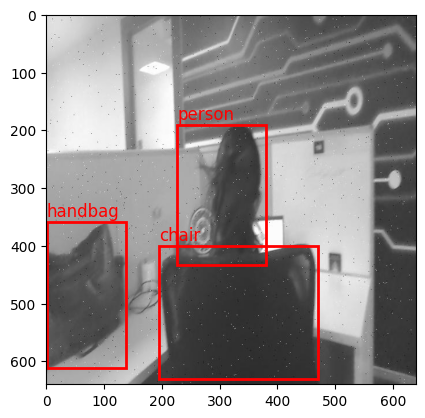

In [14]:
import os
import json
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence


# Paths to your custom dataset
images_dir = '/home/kishore-ravishankar/senior major project/Action_rec16.v1i.coco/train/'  # Change this to your images path
annotations_dir = '/home/kishore-ravishankar/senior major project/Action_rec16.v1i.coco/train/'  # Change this to your annotations path
ann_file = os.path.join(annotations_dir, '_annotations.coco.json')  # Path to the annotations file

# Load annotations from the custom JSON file
with open(ann_file, 'r') as f:
    annotations_data = json.load(f)

# Check the structure of the loaded annotations
images = annotations_data["images"]
annotations = annotations_data["annotations"]
categories = annotations_data["categories"]

# Create a dictionary for easy lookup of image metadata by image id
image_dict = {image["id"]: image for image in images}
category_dict = {category["id"]: category["name"] for category in categories}

# Function to load an image and its annotations
def load_image_and_annotations(image_id):
    image_info = image_dict.get(image_id)
    if image_info is None:
        print(f"Image ID {image_id} not found.")
        return None, None
    
    # Get image path
    img_path = os.path.join(images_dir, image_info["file_name"])
    
    # Check if image file exists
    if not os.path.exists(img_path):
        print(f"Error: Image file '{img_path}' not found!")
        return None, None
    
    # Load the image using OpenCV
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Failed to load image '{img_path}'!")
        return None, None
    
    # Get annotations (bounding boxes) for the image
    image_annotations = [ann for ann in annotations if ann["image_id"] == image_id]
    
    return img, image_annotations

# Example: Load a sample image and its annotations
sample_image_id = images[0]["id"]  # Using the first image in the dataset
img, image_annotations = load_image_and_annotations(sample_image_id)

# If the image and annotations are loaded successfully, display them
if img is not None and image_annotations is not None:
    # Display image with bounding boxes
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    for ann in image_annotations:
        x, y, w, h = ann["bbox"]
        category_name = category_dict[ann["category_id"]]
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none'))
        plt.text(x, y - 10, category_name, color='r', fontsize=12)
    plt.show()
else:
    print("Failed to load the image or annotations.")


In [16]:
import os
import json
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

# Paths to your custom dataset
images_dir = '/home/kishore-ravishankar/senior major project/Action_rec16.v1i.coco/train/'
annotations_dir = '/home/kishore-ravishankar/senior major project/Action_rec16.v1i.coco/train/'
ann_file = os.path.join(annotations_dir, '_annotations.coco.json')

# Load annotations from the custom JSON file
with open(ann_file, 'r') as f:
    annotations_data = json.load(f)

# Extract images, annotations, and categories
images = annotations_data["images"]
annotations = annotations_data["annotations"]
categories = annotations_data["categories"]

# Create a dictionary for easy lookup of image metadata by image id
image_dict = {image["id"]: image for image in images}
category_dict = {category["id"]: category["name"] for category in categories}

# Preprocess the image: Resize and normalize
def preprocess_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Error loading image at path {img_path}")
    
    img = cv2.resize(img, target_size)
    img = img.astype('float32')  # Convert to float32
    img = preprocess_input(img)  # Normalize for VGG16 or use your model's method
    return img

# Custom data generator for training
class CustomDataGenerator(Sequence):
    def __init__(self, annotations_data, images_dir, batch_size=32, target_size=(224, 224)):
        self.annotations_data = annotations_data
        self.images_dir = images_dir
        self.batch_size = batch_size
        self.target_size = target_size
        
        # Extract images, annotations, and categories from annotations_data
        self.images = annotations_data["images"]
        self.annotations = annotations_data["annotations"]
        self.categories = annotations_data["categories"]
        
        self.image_dict = {image["id"]: image for image in self.images}
        self.category_dict = {category["id"]: category["name"] for category in self.categories}
        
        # Group annotations by image_id
        self.image_annotations = {}
        for ann in self.annotations:
            if ann["image_id"] not in self.image_annotations:
                self.image_annotations[ann["image_id"]] = []
            self.image_annotations[ann["image_id"]].append(ann)
        
    def __len__(self):
        # Returns the number of batches per epoch
        return int(np.floor(len(self.images) / self.batch_size))
    
    def __getitem__(self, index):
        # Get the batch of images and annotations
        batch_images = self.images[index * self.batch_size : (index + 1) * self.batch_size]
        
        images = []
        labels = []
        for img in batch_images:
            img_path = os.path.join(self.images_dir, img["file_name"])
            img_data = preprocess_image(img_path, self.target_size)
            images.append(img_data)
            
            # Get bounding box annotations for the image
            image_annotations = self.image_annotations.get(img["id"], [])
            boxes = []
            for ann in image_annotations:
                x, y, w, h = ann["bbox"]
                class_id = ann["category_id"]
                boxes.append([x, y, w, h, class_id])  # Add class_id to bounding box info
            labels.append(np.array(boxes))  # Append the bounding boxes and class_ids for this image
        
        return np.array(images), np.array(labels)

# Initialize the data generator
train_generator = CustomDataGenerator(annotations_data, images_dir, batch_size=4)

# Example: Getting a batch
images, labels = train_generator[0]

# Display the first image in the batch with bounding boxes
plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
for bbox in labels[0]:
    x, y, w, h, class_id = bbox
    category_name = self.category_dict.get(class_id, "Unknown")
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none'))
    plt.text(x, y - 10, category_name, color='r', fontsize=12)
plt.show()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-98.68..151.061].


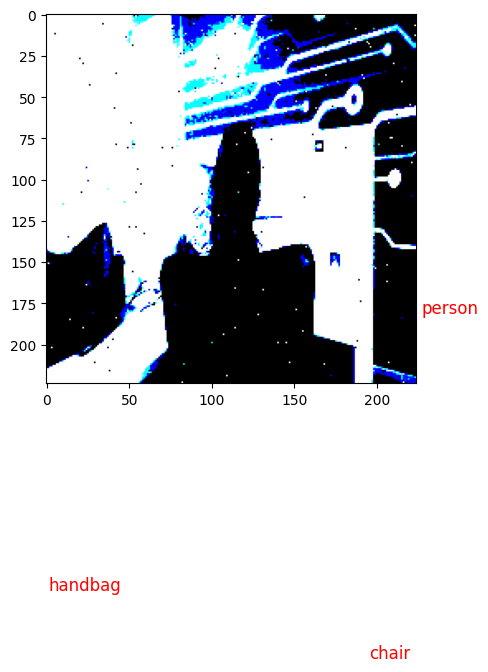

In [17]:
import os
import json
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

# Paths to your custom dataset
images_dir = '/home/kishore-ravishankar/senior major project/Action_rec16.v1i.coco/train/'
annotations_dir = '/home/kishore-ravishankar/senior major project/Action_rec16.v1i.coco/train/'
ann_file = os.path.join(annotations_dir, '_annotations.coco.json')

# Load annotations from the custom JSON file
with open(ann_file, 'r') as f:
    annotations_data = json.load(f)

# Extract images, annotations, and categories
images = annotations_data["images"]
annotations = annotations_data["annotations"]
categories = annotations_data["categories"]

# Create a dictionary for easy lookup of image metadata by image id
image_dict = {image["id"]: image for image in images}
category_dict = {category["id"]: category["name"] for category in categories}

# Preprocess the image: Resize and normalize
def preprocess_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Error loading image at path {img_path}")
    
    img = cv2.resize(img, target_size)
    img = img.astype('float32')  # Convert to float32
    img = preprocess_input(img)  # Normalize for VGG16 or use your model's method
    return img

# Custom data generator for training
class CustomDataGenerator(Sequence):
    def __init__(self, annotations_data, images_dir, batch_size=32, target_size=(224, 224), max_boxes=100):
        self.annotations_data = annotations_data
        self.images_dir = images_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.max_boxes = max_boxes  # Max number of boxes per image (for padding)
        
        # Extract images, annotations, and categories from annotations_data
        self.images = annotations_data["images"]
        self.annotations = annotations_data["annotations"]
        self.categories = annotations_data["categories"]
        
        self.image_dict = {image["id"]: image for image in self.images}
        self.category_dict = {category["id"]: category["name"] for category in self.categories}
        
        # Group annotations by image_id
        self.image_annotations = {}
        for ann in self.annotations:
            if ann["image_id"] not in self.image_annotations:
                self.image_annotations[ann["image_id"]] = []
            self.image_annotations[ann["image_id"]].append(ann)
        
    def __len__(self):
        # Returns the number of batches per epoch
        return int(np.floor(len(self.images) / self.batch_size))
    
    def __getitem__(self, index):
        # Get the batch of images and annotations
        batch_images = self.images[index * self.batch_size : (index + 1) * self.batch_size]
        
        images = []
        labels = []
        for img in batch_images:
            img_path = os.path.join(self.images_dir, img["file_name"])
            img_data = preprocess_image(img_path, self.target_size)
            images.append(img_data)
            
            # Get bounding box annotations for the image
            image_annotations = self.image_annotations.get(img["id"], [])
            boxes = []
            for ann in image_annotations:
                x, y, w, h = ann["bbox"]
                class_id = ann["category_id"]
                boxes.append([x, y, w, h, class_id])  # Add class_id to bounding box info
                
            # If there are fewer boxes than max_boxes, pad with zeros
            while len(boxes) < self.max_boxes:
                boxes.append([0, 0, 0, 0, 0])  # Padding box (empty)
                
            labels.append(np.array(boxes))  # Append the bounding boxes and class_ids for this image
        
        return np.array(images), np.array(labels)

# Initialize the data generator
train_generator = CustomDataGenerator(annotations_data, images_dir, batch_size=4)

# Example: Getting a batch
images, labels = train_generator[0]

# Display the first image in the batch with bounding boxes
plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
for bbox in labels[0]:
    x, y, w, h, class_id = bbox
    if class_id != 0:  # Skip padded boxes (class_id 0)
        category_name = category_dict.get(class_id, "Unknown")
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none'))
        plt.text(x, y - 10, category_name, color='r', fontsize=12)
plt.show()


In [12]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib

# Paths to your custom dataset
images_dir = '/home/kishore-ravishankar/senior major project/Action_rec16.v1i.coco/train/'  # Change this to your images path
annotations_dir = '/home/kishore-ravishankar/senior major project/Action_rec16.v1i.coco/train/'  # Change this to your annotations path
ann_file = os.path.join(annotations_dir, '_annotations.coco.json')  # Path to the annotations file

# Load annotations from the custom JSON file
with open(ann_file, 'r') as f:
    annotations_data = json.load(f)

# Extract necessary info from the annotations
images = annotations_data["images"]
annotations = annotations_data["annotations"]
categories = annotations_data["categories"]
category_dict = {category["id"]: category["name"] for category in categories}

# Function to load and preprocess image
def load_and_preprocess_image(image_id):
    image_info = next(image for image in images if image['id'] == image_id)
    img_path = os.path.join(images_dir, image_info['file_name'])
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # Resize image to 224x224 for VGG16
    img_array = img_to_array(img) / 255.0  # Normalize the image
    return img_array

# Ensure the bounding box is within the image dimensions and crop the image
def crop_and_resize_image(img, x, y, w, h, target_size=(640, 640)):
    # Ensure no negative values for width or height
    if w <= 0:
        w = 1  # Set width to 1 if it's non-positive
    if h <= 0:
        h = 1  # Set height to 1 if it's non-positive
    
    # Check if the bounding box is valid, i.e., it should fit inside the image
    if x + w > img.shape[1]:
        w = img.shape[1] - x
    if y + h > img.shape[0]:
        h = img.shape[0] - y
    
    # Convert coordinates to integers to avoid slice index errors
    x, y, w, h = map(int, [x, y, w, h])

    # Debug: print bounding box details
    if w <= 0 or h <= 0:
        print(f"Warning: Invalid bounding box (x={x}, y={y}, w={w}, h={h})")

    cropped_img = img[y:y+h, x:x+w]
    
    # If the cropped image is non-empty, resize it
    if cropped_img.size > 0:
        resized_img = cv2.resize(cropped_img, target_size)
        return resized_img
    else:
        print(f"Warning: Empty cropped image for bounding box ({x}, {y}, {w}, {h})")
        return None  # Return None if the crop resulted in an empty image

# Prepare dataset (images and corresponding features)
X_train = []  # List of feature vectors
y_train = []  # List of labels

for image_info in images:
    image_id = image_info["id"]
    img = load_and_preprocess_image(image_id)
    
    # Get annotations for the image
    image_annotations = [ann for ann in annotations if ann["image_id"] == image_id]
    
    for ann in image_annotations:
        x, y, w, h = ann["bbox"]
        category_name = category_dict[ann["category_id"]]  # Get the category name
        
        # Crop and resize the image using the modified function
        cropped_img_resized = crop_and_resize_image(img, x, y, w, h, target_size=(640, 640))
        
        if cropped_img_resized is not None:  # Only append if crop was successful
            X_train.append(cropped_img_resized)
            y_train.append(ann["category_id"])  # Use category_id directly

# Convert X_train and y_train to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)  # y_train now contains category IDs

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=len(categories))

# Build a CNN model for feature extraction (VGG16)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(640, 640, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
feature_extractor_model = Model(inputs=base_model.input, outputs=x)

# Extract features from images using the CNN model (VGG16)
X_features = feature_extractor_model.predict(X_train)

# Train a Random Forest classifier on the features
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_features, np.argmax(y_train, axis=1))  # Train on the extracted features

# Evaluate the classifier
y_pred = rf_classifier.predict(X_features)
accuracy = accuracy_score(np.argmax(y_train, axis=1), y_pred)
print(f"Random Forest Classifier Accuracy: {accuracy * 100:.2f}%")

# Save the Random Forest model
joblib.dump(rf_classifier, 'random_forest_model.pkl')

# Save the feature extraction model (CNN)
feature_extractor_model.save('vgg16_feature_extractor.h5')  # Save the CNN model separately

print("Models saved as vgg16_feature_extractor.h5 and random_forest_model.pkl")


E0000 00:00:1737348442.602245   23077 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1737348442.605597   23077 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2025-01-20 10:17:22.608240: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at xla_ops.cc:577 : FAILED_PRECONDITION: DNN library initialization failed. Look at the er

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/kishore-ravishankar/workspacelab/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/kishore-ravishankar/workspacelab/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/kishore-ravishankar/workspacelab/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/kishore-ravishankar/workspacelab/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/kishore-ravishankar/workspacelab/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/kishore-ravishankar/workspacelab/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/kishore-ravishankar/workspacelab/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/kishore-ravishankar/workspacelab/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/kishore-ravishankar/workspacelab/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/kishore-ravishankar/workspacelab/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/kishore-ravishankar/workspacelab/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/kishore-ravishankar/workspacelab/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/kishore-ravishankar/workspacelab/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/kishore-ravishankar/workspacelab/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/kishore-ravishankar/workspacelab/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/kishore-ravishankar/workspacelab/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/kishore-ravishankar/workspacelab/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_18328/437871612.py", line 109, in <module>

  File "/home/kishore-ravishankar/workspacelab/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/kishore-ravishankar/workspacelab/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 559, in predict

  File "/home/kishore-ravishankar/workspacelab/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 256, in one_step_on_data_distributed

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_data_distributed_1188]